In [1]:
%pylab
%load_ext autoreload
%autoreload 2
from pySurf.data2D_class import Data2D
from pySurf.readers.format_reader import csvZygo_reader
from pySurf.readers.instrumentReader import matrixdat_reader

import os
from dataIO.span import span


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

Some details about shared axis and subplots. First thing to have clear is that shared axis is related to the "extent" of axis, and has nothing to do with axis size. So, if I create shared axis on plots of different sizes, this has no effect on the plot size.

The mechanism for generating subplots with `plt.subplot` is as simple as it can be (`plt.subplots` and `plt.gridspec` offer completely equivalent mechanisms, as far as I understand), this normally work:

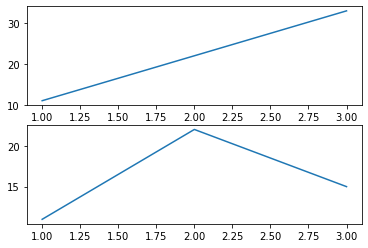

In [3]:
plt.figure()
ax1 = plt.subplot(211)
plt.plot([1,2,3],[11,22,33])
plt.subplot(212, sharex = ax1)
plt.plot([1,2,3],[11,22,15])

The above example works well, and figure can be safely resized. However it is more difficult to combine an image and a data plot, when the `aspect` property of the image plot must be kept into account.
In the minimal example below, the image plot is forced to be square, because of the `aspect = 'equal'` option, which determines its width in the allocated vertical space. The plot to the bottom doesn't have such constrain, and can span over the entire figure. As already mentioned, the shared x axis has effect on the extent, not on the dimensions.

In [4]:
# minimal example, create data and initialize
# data have frame at 1 pixel distance from border

nx=300
ny=300
x = np.arange(nx)
y = np.arange(ny)
data = np.random.random(nx*ny).reshape((ny,nx))

data[1,:]=1
data[:,-2]=1
data[-2,:]=1
data[:,1]=1

plt.close('all')

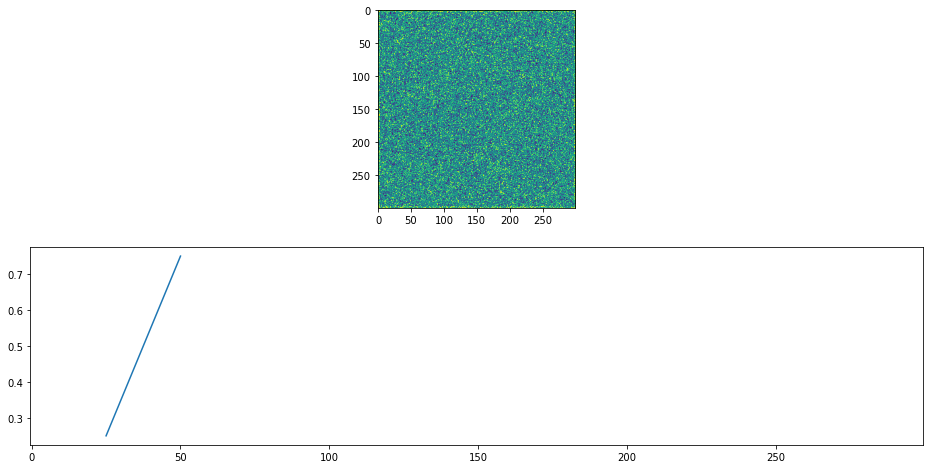

In [5]:
# minimal example

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax1.imshow(data,aspect='equal')
#x1.set_adjustable("box",share=True)

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot([25,50],[0.25,0.75])



This is equivalent, using `gridspec`: 

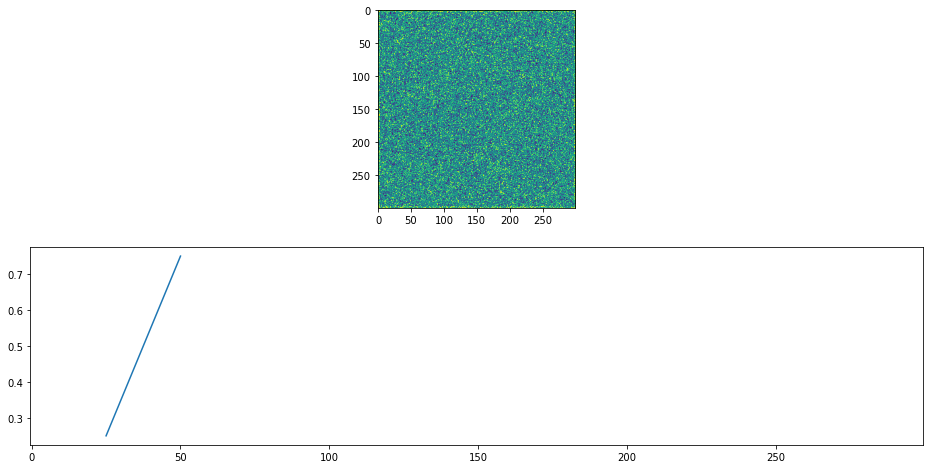

In [6]:
import matplotlib.gridspec as gridspec

plt.close('all')

fig2 = plt.figure(figsize=(16,8))
spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.imshow(data,aspect='equal')

ax2 = fig2.add_subplot(spec2[1, 0],sharex=ax1)
ax2.plot([25,50],[0.25,0.75])

Previously, I was solving the problem with a trick, that suddenly doesn't work any more because of a change in matplotlib (see warning): colorbar was added and removed to the line plot, but the colorbar was referred to the last defined mappable (line plot has no mappable).

    C:\Users\kovor\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
     app.launch_new_instance()
     
The code below was also implemented inside a function `plot_data` and derived multi-plot derived functions.

In [26]:
# questo improvvisamente non funziona, il colorbar.remove
#  ridimensiona il grafico precedente.

import numpy
from matplotlib import pyplot as plt

nx,ny = 200,100

x = np.arange(nx)
y = np.arange(ny)
data = np.random.rand(nx*ny).reshape((ny,nx))

ax2=plt.subplot(211,sharex=ax1)
plt.imshow(data,extent = [min(x),max(x),min(y),max(y)],aspect='auto')
plt.colorbar()

ax3=plt.subplot(212,sharex=ax1)
plt.plot(x,np.sum(data,axis=0))  #sum along y
plt.colorbar().remove() #dirty trick to adjust size to other panels

C:\Users\kovor\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  app.launch_new_instance()


The size of subplot in relation to figure size is determined by the `adjustable` property. The most detailed source I found on the topic is at https://stackoverflow.com/questions/32633322/changing-aspect-ratio-of-subplots-in-matplotlib

from which following example is taken:


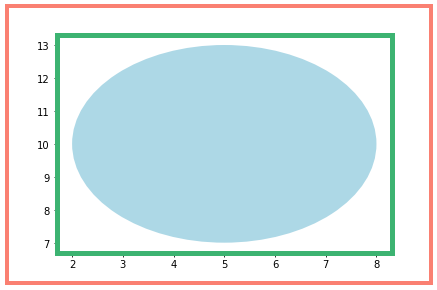

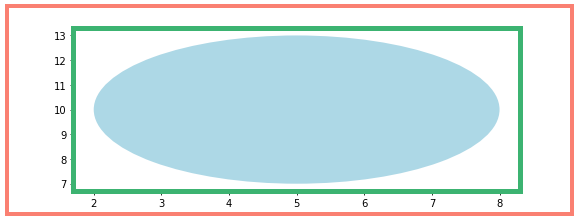

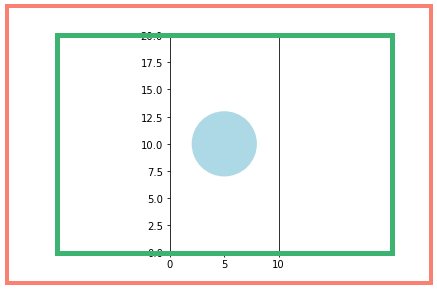

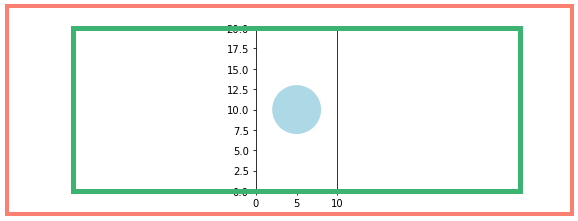

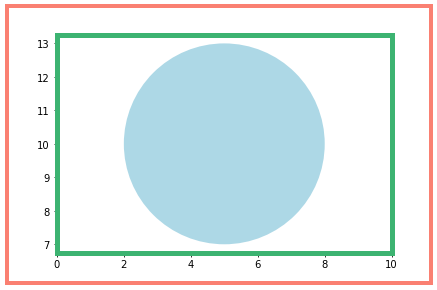

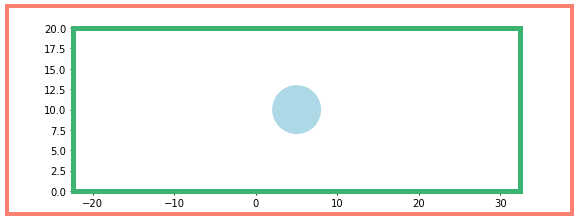

In [7]:
import matplotlib.pyplot as plt

def main():
    resized = (8, 3)

    basic_example()
    basic_example(resized)

    fixed_aspect()
    fixed_aspect(resized)

    fixed_aspect_datalim()
    fixed_aspect_datalim(resized)

    plt.show()

def basic_example(figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    circ = plt.Circle((5, 10), 3, facecolor='lightblue')
    ax.add_patch(circ)
    ax.margins(0.05)
    show_bounds(ax)
    return ax

def fixed_aspect(figsize=None):
    ax = basic_example(figsize)
    ax.set(xlim=[0, 10], ylim=[0, 20], aspect=1)
    return ax

def fixed_aspect_datalim(figsize=None):
    fixed_aspect(figsize).set(adjustable='datalim')

def show_bounds(ax):
    axes_box = ax.get_position().bounds
    # Maximum Axes size
    fig_box(ax, axes_box, lw=5, ec='mediumseagreen', zorder=10)
    # Figure outline
    fig_box(ax, (0.01, 0.02, 0.98, 0.96), lw=4, ec='salmon')

def fig_box(ax, bounds, **kwargs):
    left, bottom, width, height = bounds
    rect = plt.Rectangle((left, bottom), width, height, **kwargs)
    rect.set(clip_on=False, facecolor='none', transform=ax.figure.transFigure)
    ax.add_artist(rect)
    return rect

main()

The suggested solution for the mixed imshow-plot case, is using `adjustable = 'box-forced'` setting, but this is no more a valid option in current version (only `datalim` and `box` are acceptable values). 

`datalim` changes the behavior, but not in a useful way as it cuts the data along vertical direction:



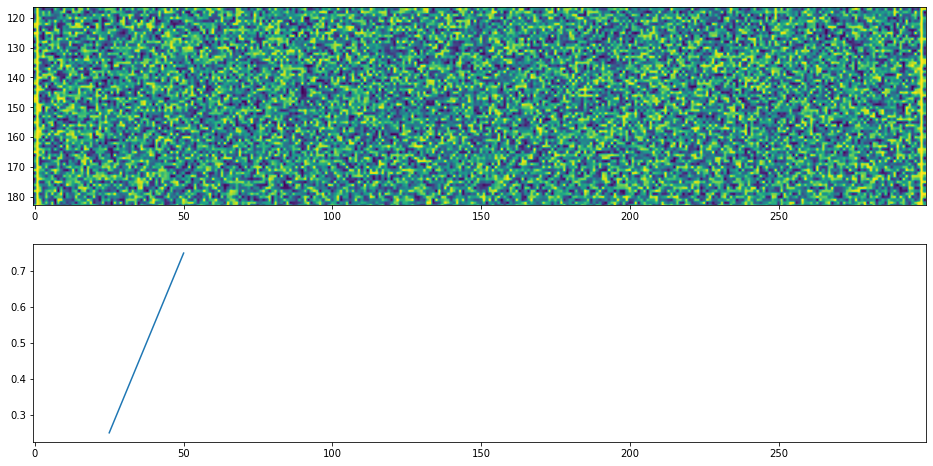

In [8]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax1.imshow(data,aspect='equal')
ax1.set_adjustable("datalim",share=True)

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot([25,50],[0.25,0.75])


In [15]:
%matplotlib qt

It is possible to "solve" the issue by manually setting the size of second subplot on the base of the first, similarly to what suggested at https://stackoverflow.com/questions/38863262/change-subplot-size-in-python-matplotlib. The problem with this approach is that when figure is resized the size of the subplots is lost (set interactive mode with `%matplotlib qt` to experience the effect). 

In [25]:
# manually adjust subplot sizes
# it doesn't work on resizing

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax1.imshow(data,aspect='equal')
#x1.set_adjustable("box",share=True)

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot([25,50],[0.25,0.75])

box1 = ax1.get_position()
box2 = ax2.get_position()
ax2.set_position([box1.x0, box2.y0, box1.width , box2.height])
ax2.set_adjustable("box",share=True)


A good solution is offered in this post https://stackoverflow.com/questions/43352931/matplotlib-subplot-imshow-plot with the function `make_axes_locatable`:


In [21]:
# make_axes_locatable solves the problem, 
#  figures are cut if resized to smaller size, 
#  I don't know better how to fix this. 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np; np.random.seed(0)

plt.figure

fig, ax1 = plt.subplots()
ax1.imshow(data)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(ax1)
#ax2 = divider.append_axes("bottom", size=1.2, pad=0.3, sharex=ax1)
ax2 = divider.append_axes("bottom", size=1.2, pad=0.3, sharex=ax1)
#axright = divider.append_axes("right", size=1.2, pad=0.4, sharey=ax)
#plot to the new axes
ax2.plot([25,50],[0.25,0.75])

#axtop.margins(x=0)
plt.tight_layout()
plt.show()

However this doesn't work when applying a colorbar, as the colorbar is applied to the entire figure, not to the single subplot:

In [22]:
# make_axes_locatable solves the problem, 
#  figures are cut if resized to smaller size, 
#  I don't know better how to fix this. 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np; np.random.seed(0)

plt.figure

fig, ax1 = plt.subplots()
plt.imshow(data,aspect='auto')
plt.colorbar()

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(ax1)
#ax2 = divider.append_axes("bottom", size=1.2, pad=0.3, sharex=ax1)
ax2 = divider.append_axes("bottom", size=1.2, pad=0.3, sharex=ax1)
#axright = divider.append_axes("right", size=1.2, pad=0.4, sharey=ax)
#plot to the new axes
ax2.plot([25,50],[0.25,0.75])

#axtop.margins(x=0)
plt.tight_layout()
plt.show()

Similar problem is described here: https://stackoverflow.com/questions/41985565/how-to-use-twinx-with-ax-created-with-make-axes-locatable#.

The code had some problem for the example in the post, but seems to work for our case:

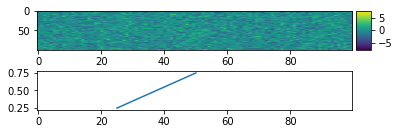

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


data = np.random.normal(0,2,size=(100,100))

fig     = plt.figure()
ax      = fig.add_subplot(2,1,1)
im      = plt.imshow(data,aspect='auto') #ax.imshow(data,cmap="bone")

divider = make_axes_locatable(ax)
ax1     = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=ax1) 
#plt.colorbar()  

ax2     = divider.append_axes("bottom",size="100%",pad = 0.3,sharex = ax)
#n,bins,patches = ax2.hist(data.flatten(),bins=20)
#ax3     = ax2.twinx()
#ax3.plot(bins[:-1],np.cumsum(n*100/np.size(data)),lw=2)
ax2.plot([25,50],[0.25,0.75])

plt.show()

However the above solution cannot be implemented enclosing the firs plot in a separate function, because the divider must be made accessible from outside in order to add more axis.

The only solution I could find is described in https://stackoverflow.com/questions/41985565/how-to-use-twinx-with-ax-created-with-make-axes-locatable#, and consists in manually recalculating all positions on resize:

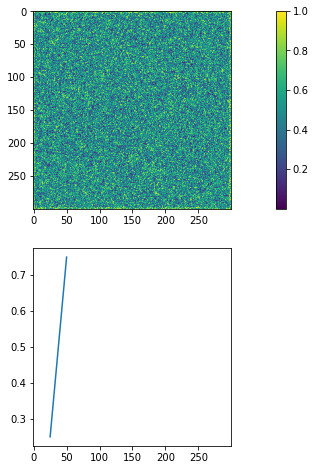

In [12]:
fig = plt.figure(figsize=(16,8))

ax1 = plt.subplot(211)
plt.imshow(data,aspect='equal')
#x1.set_adjustable("box",share=True)
plt.colorbar()

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot([25,50],[0.25,0.75])

def resize(event):
    box1 = ax1.get_position()
    box2 = ax2.get_position()
    ax2.set_position([box1.x0, box2.y0, box1.width , box2.height])
    ax2.set_adjustable("box",share=True)

cid = fig.canvas.mpl_connect('draw_event', resize)
cid2 = fig.canvas.mpl_connect('resize_event', resize)

resize(None)


In [27]:
%matplotlib inline

This was incorporated in `pyXSurf` library code, see examples below.

Use the most basic `plot_data` function:

In [29]:
from pySurf.data2D import plot_data

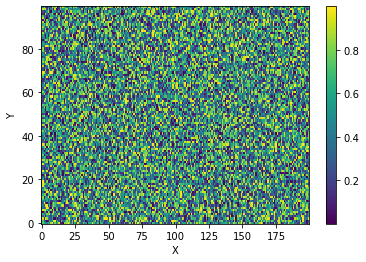

In [30]:
plt.clf()
plot_data(data,x,y,aspect='auto')

With `equal` aspect:

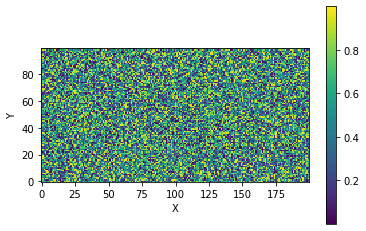

In [32]:
plt.clf()
plot_data(data,x,y,aspect='equal')

Adding additional axis:

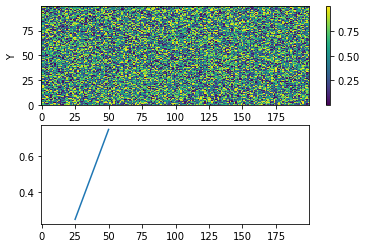

In [34]:
# questo testa l'aggiunta di assi a plot_data, funzionante

plt.close('all')

fig     = plt.figure()
ax1      = plt.subplot(211) #fig.add_subplot(2,1,1)


axim = plot_data(data,x,y,aspect='auto') # axim not used for axis synch

'''
axim      = plt.imshow(data,aspect='auto')
divider = make_axes_locatable(ax1)

# usare plt.colorbar funziona, usare le altre due righe non aggiorna alla prima
#axb     = divider.append_axes("right", size="5%", pad=0.05) 
#plt.colorbar(cax=axb)
plt.colorbar()  
'''

ax2 = plt.subplot(212,sharex=ax1)
ax2.plot([25,50],[0.25,0.75])

def resize(event):
    box1 = ax1.get_position()
    box2 = ax2.get_position()
    ax2.set_position([box1.x0, box2.y0, box1.width , box2.height])
    ax2.set_adjustable("box",share=True)

cid = fig.canvas.mpl_connect('draw_event', resize)
cid2 = fig.canvas.mpl_connect('resize_event', resize)

resize(None)

Three axis as implemented in psd2d:

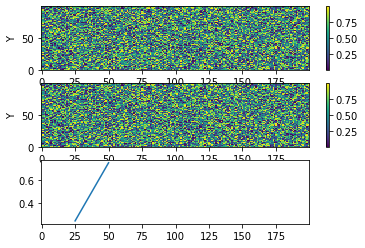

In [35]:
# qua con tre subplots ricalcando plot_psd2d

plt.close('all')

fig     = plt.figure()
ax1      = plt.subplot(311) #fig.add_subplot(2,1,1)
axim = plot_data(data,x,y,aspect='auto') # axim not used for axis sync

ax2 = plt.subplot(312,sharex=ax1)
axim2 = plot_data(data,x,y,aspect='auto') # axim not used for axis sync

ax3 = plt.subplot(313,sharex=ax1)
ax3.plot([25,50],[0.25,0.75])


def resize(event):
    box1 = ax1.get_position()
    box2 = ax2.get_position()
    box3 = ax3.get_position()
    ax2.set_position([box1.x0, box2.y0, box1.width , box2.height])
    ax2.set_adjustable("box",share=True)
    ax3.set_position([box1.x0, box3.y0, box1.width , box3.height])
    ax3.set_adjustable("box",share=True)

cid = fig.canvas.mpl_connect('draw_event', resize)
cid2 = fig.canvas.mpl_connect('resize_event', resize)

resize(None)

#plt.tight_layout()



Calling functions implementation in `psd2d`:

In [36]:
from pySurf.psd2d import psd2d_analysis

<Figure size 1920x1080 with 0 Axes>

option stats==1 is obsolete. Please replace it with a dictionary including options for `get_stats`. c to continue, q to quit.


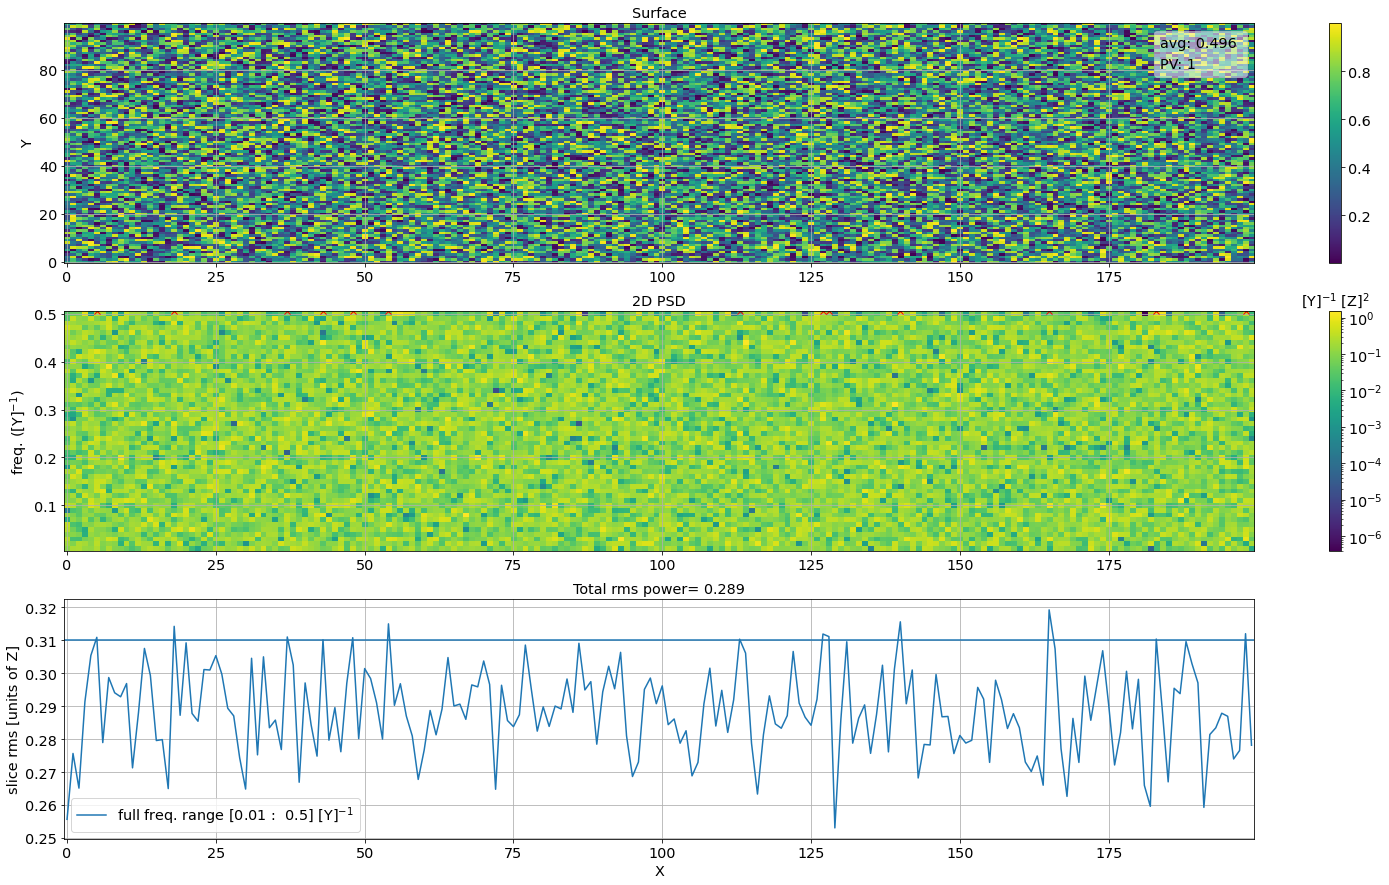

In [45]:
#test dopo incorporazione
rmsthr=0.31
p2 = psd2d_analysis(data,x,y,aspect='auto',rmsthr=rmsthr,title="")

<Figure size 1920x1080 with 0 Axes>

option stats==1 is obsolete. Please replace it with a dictionary including options for `get_stats`. c to continue, q to quit.


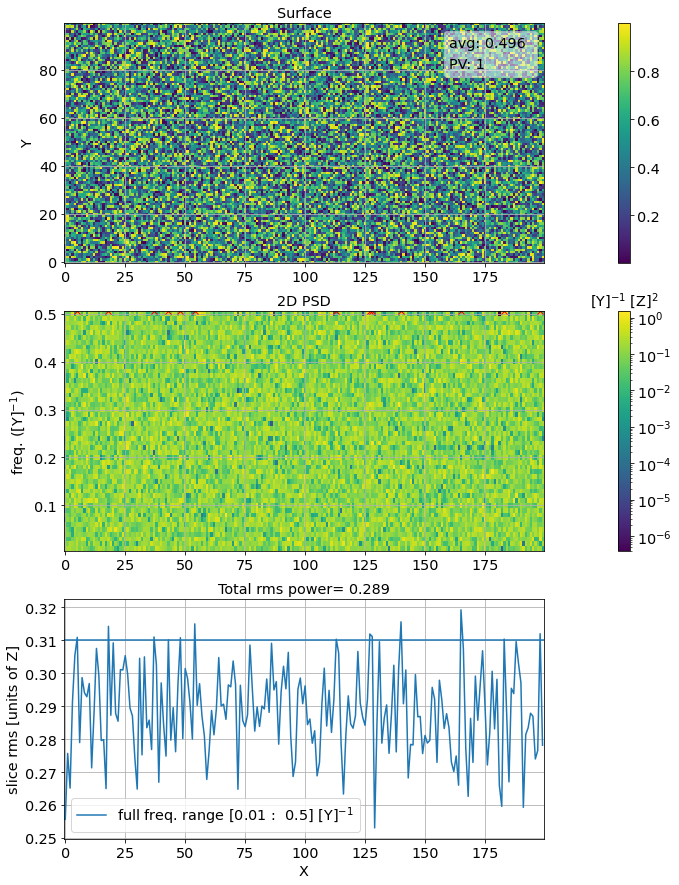

In [44]:
rmsthr=0.31
p2 = psd2d_analysis(data,x,y,aspect='equal',rmsthr=rmsthr,title="")

Other posts more losely related:

https://stackoverflow.com/questions/50298305/how-to-force-same-size-between-matplotlib-subplot-image-axes

https://stackoverflow.com/questions/37767026/matplotlib-enforce-equal-size-height-of-subplots

https://stackoverflow.com/questions/47351874/how-to-use-sharex-and-sharey-combined-with-aspect-equal-and-adjustable-box-forc

https://stackoverflow.com/questions/13629994/new-pythonic-style-for-shared-axes-square-subplots-in-matplotlib

https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
